# Object Detection Using YOLO v5

### Step 1: Dataset Exploration and Clone github repository

In [1]:
 %cd /root/ass2

/root/ass2


In [3]:
import os
from collections import defaultdict

def analyze_yolo_format(images_folder, labels_folder):
    class_counts = defaultdict(int)
    total_annotations = 0

    # Get a list of all image file names without extensions
    image_files = {os.path.splitext(f)[0]: f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))}

    # Iterate over annotation text files in the labels folder
    for filename in os.listdir(labels_folder):
        if not filename.endswith('.txt'):
            continue
        base_filename = os.path.splitext(filename)[0]
        if base_filename in image_files:  # Check if there's a corresponding image file
            with open(os.path.join(labels_folder, filename), 'r') as file:
                lines = file.readlines()
                total_annotations += len(lines)
                for line in lines:
                    class_id = int(line.split()[0])  # Assuming class ID is the first item on each line
                    class_counts[class_id] += 1

    return class_counts, total_annotations

# Example usage:
images_folder = '/root/ass2/dataset/Object_Detection/yolo/train/images/'
labels_folder = '/root/ass2/dataset/Object_Detection/yolo/train/labels/'
class_counts, total_annotations = analyze_yolo_format(images_folder, labels_folder)
print("Number of images per class:", class_counts)
print("Total number of annotations:", total_annotations)


Number of images per class: defaultdict(<class 'int'>, {3: 2494, 2: 4421, 1: 1132, 0: 1421, 4: 4235})
Total number of annotations: 13703


In [3]:
# By Default Cloned under /content/
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.07 MiB | 11.92 MiB/s, done.
Resolving deltas: 100% (11376/11376), done.
Updating files: 100% (148/148), done.


In [3]:
%cd yolov5
from yolov5 import utils
#display = utils.notebook_init()  # checks Pytorch and GPU used
!pip install -r requirements.txt

/root/ass2/yolov5
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached pillow-10.3.0-cp39-cp39-manylinux_2_28_x86_64.whl (4.5 MB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 8.1 MB/s eta 0:00:0000:01
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Step 2: Setup Training Configuration

In [4]:
#@title Setup Training YAML File
number_of_classes = 5 #@param {type:"integer"} # we have five classes
with open('new_train_yaml', 'w+') as file:
    file.write(
        f"""
        # parameters
        nc: {number_of_classes}  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors 
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

### Step 3: Setup Dataset paths

In [16]:
#@title Setup Dataset Configuration (Data.yaml)
train_data_dir = "/root/ass2/dataset/Object_Detection/yolo/train" #@param {type:"string"}
val_data_dir = "/root/ass2/dataset/Object_Detection/yolo/valid" #@param {type:"string"}
test_data_dir = "/root/ass2/dataset/Object_Detection/yolo/test" #@param {type:"string"}

class_names = ['Ready', 'empty_pod', 'germination', 'pod', 'young'] #@param {type:"raw"}
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train_data_dir}
        val: {val_data_dir}
        test: {test_data_dir}

        nc: {number_of_classes}
        names: {class_names}
        """
    )

### Step 4: Start Training

* Configuation to try:

- Image Size: 416
- Batch Size: 16
- Epochs: 300
- Data Source details : new_data_yaml (Created earlier)
- Training details : new_train_yaml (Created earlier)

In [7]:
## ENTER CODE TO START TRAINING ##
!python /root/ass2/yolov5/train.py --img 416 --batch 16 --epochs 300 --data /root/ass2/yolov5/new_data_yaml --cfg /root/ass2/yolov5/new_train_yaml

train: weights=yolov5s.pt, cfg=/root/ass2/yolov5/new_train_yaml, data=/root/ass2/yolov5/new_data_yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-304-g22361691 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14931MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, wa

#### Performance on train, val and test set

In [17]:
!python val.py --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --data new_data_yaml --img 416 --half --task train

val: data=new_data_yaml, weights=['/root/ass2/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-304-g22361691 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14931MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
train: Scanning /root/ass2/dataset/Object_Detection/yolo/train/labels.cache... 1
INFO:root:Using NamedTuple = typing._NamedTuple instead.
[2024-04-28 03:54:06.486 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:462 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-04-28 03:54:06.513 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:462 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/inpu

In [18]:
!python val.py --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --data new_data_yaml --img 416 --half --task val

val: data=new_data_yaml, weights=['/root/ass2/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-304-g22361691 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14931MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
val: Scanning /root/ass2/dataset/Object_Detection/yolo/valid/labels.cache... 226
INFO:root:Using NamedTuple = typing._NamedTuple instead.
[2024-04-28 03:54:40.850 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:527 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-04-28 03:54:40.880 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:527 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/

In [19]:
!python val.py --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --data new_data_yaml --img 416 --half --task test

val: data=new_data_yaml, weights=['/root/ass2/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-304-g22361691 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14931MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
test: Scanning /root/ass2/dataset/Object_Detection/yolo/test/labels.cache... 226
INFO:root:Using NamedTuple = typing._NamedTuple instead.
[2024-04-28 03:55:00.899 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:595 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-04-28 03:55:00.928 pytorch-1-13-gpu-py-ml-g4dn-xlarge-4b7f7c67f5f608864b46ffc7ff71:595 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input

### Step 5: Test the trained model on sample images

In [5]:
## ENTER CODE TO START INFERENCE ON THE IMAGES
# !python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/valid/images/100035.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
# !python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/valid/images/100045.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
# !python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/valid/images/100085.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
# !python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/valid/images/100094.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt
 
!python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/test/images/100337.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
!python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/test/images/100555.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
!python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/test/images/100575.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt 
!python /root/ass2/yolov5/detect.py --source /root/ass2/dataset/Object_Detection/yolo/test/images/100654.jpg --weights /root/ass2/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --save-txt

detect: weights=['/root/ass2/yolov5/runs/train/exp/weights/best.pt'], source=/root/ass2/dataset/Object_Detection/yolo/test/images/100337.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-304-g22361691 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14931MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
image 1/1 /root/ass2/dataset/Object_Detection/yolo/test/images/100337.jpg: 256x416 9 Readys, 12.4ms
Speed: 0.4ms pre-process, 12.4ms inference, 2.2ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp5
1 labels saved to runs/detect/exp5/labels
detect:

### Step 6: Display result images

In [10]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline

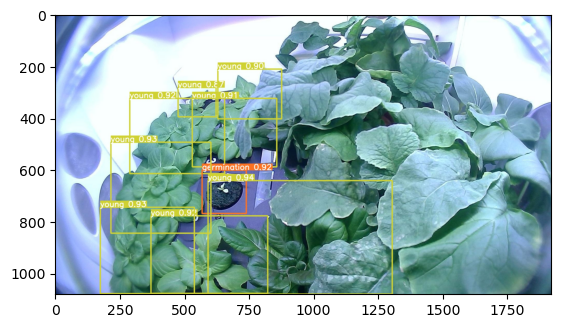

In [11]:
# Check under ../yolov5/runs/detect
image = Image.open('/root/ass2/yolov5/runs/detect/exp/100035.jpg')
plt.imshow(image)

### Step 7: Display performance analysis

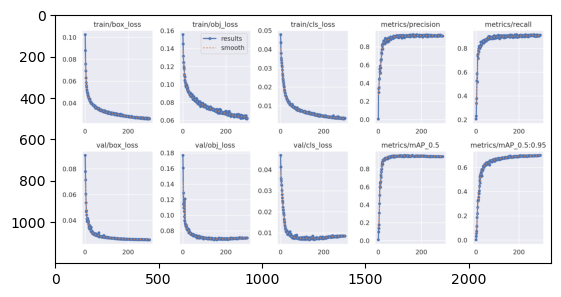

In [12]:
image = Image.open('/root/ass2/yolov5/runs/train/exp/results.png') # Change 'exp' to the last in the train directory
plt.imshow(image)